# SinkVis Demo: Attention Sinks & KV Cache Eviction

This notebook demonstrates:
1. Loading GPT-2 and capturing attention patterns
2. Visualizing attention sinks with SinkVis
3. Comparing eviction policies
4. **Needle in a Hayst

## Setup


In [ ]:
# Install sinkvis package from py-package directory
from pathlib import Path
import sys
import importlib
import subprocess

package_path = Path.cwd().parent / "sinkvis"
print(f"Installing sinkvis from: {package_path}")

# Use pip install -e for editable installation
result = subprocess.run(
    [sys.executable, "-m", "pip", "install", "-e", str(package_path), "--quiet"],
    capture_output=True,
    text=True
)
if result.returncode != 0:
    print("Installation output:", result.stdout)
    if result.stderr:
        print("Errors:", result.stderr)
    raise RuntimeError(f"Installation failed with return code {result.returncode}")

# Clear any cached imports of sinkvis
if 'sinkvis' in sys.modules:
    del sys.modules['sinkvis']
# Also clear any submodules
modules_to_remove = [m for m in sys.modules.keys() if m.startswith('sinkvis')]
for m in modules_to_remove:
    del sys.modules[m]

# Force reload the import system and import sinkvis
importlib.invalidate_caches()


Installing sinkvis from: /Users/amir/Documents/stuff/SinkVis/py-package/sinkvis


In [3]:
import sinkvis

import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

from sinkvis import SinkVis
from sinkvis.models import EvictionPolicy, SimulationConfig
from sinkvis.eviction import run_simulation

print("✓ All imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


/Users/amir/Documents/stuff/SinkVis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All imports successful
PyTorch version: 2.9.1
CUDA available: False


## Section 1: Load GPT-2 Model


In [4]:
# Load GPT-2 model and tokenizer
print("Loading GPT-2...")
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

# Set padding token
tokenizer.pad_token = tokenizer.eos_token

print(f"✓ Loaded {model_name}")
print(f"  - Layers: {model.config.n_layer}")
print(f"  - Attention heads: {model.config.n_head}")
print(f"  - Hidden size: {model.config.n_embd}")


Loading GPT-2...
✓ Loaded gpt2
  - Layers: 12
  - Attention heads: 12
  - Hidden size: 768


## Section 2: Capture Attention with SinkVis


In [5]:
# Test prompt
prompt = "The capital of France is Paris. The Eiffel Tower is a famous landmark."

# Tokenize
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]
tokens = [tokenizer.decode([tok]) for tok in input_ids[0]]

print(f"Prompt: {prompt}")
print(f"Tokens ({len(tokens)}): {tokens}")

# Use SinkVis context manager to capture attention
with SinkVis(model, tokenizer) as sv:
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    # Get attention data
    attention_data = sv.get_attention_data(layer=-1, head=0)
    
    if attention_data is not None:
        print(f"✓ Captured attention matrix: {len(attention_data)}x{len(attention_data[0])}")
    else:
        print("⚠ No attention captured")


Prompt: The capital of France is Paris. The Eiffel Tower is a famous landmark.
Tokens (17): ['The', ' capital', ' of', ' France', ' is', ' Paris', '.', ' The', ' E', 'iff', 'el', ' Tower', ' is', ' a', ' famous', ' landmark', '.']
✓ Captured attention matrix: 17x17


## Section 3: Visualize Attention Sinks


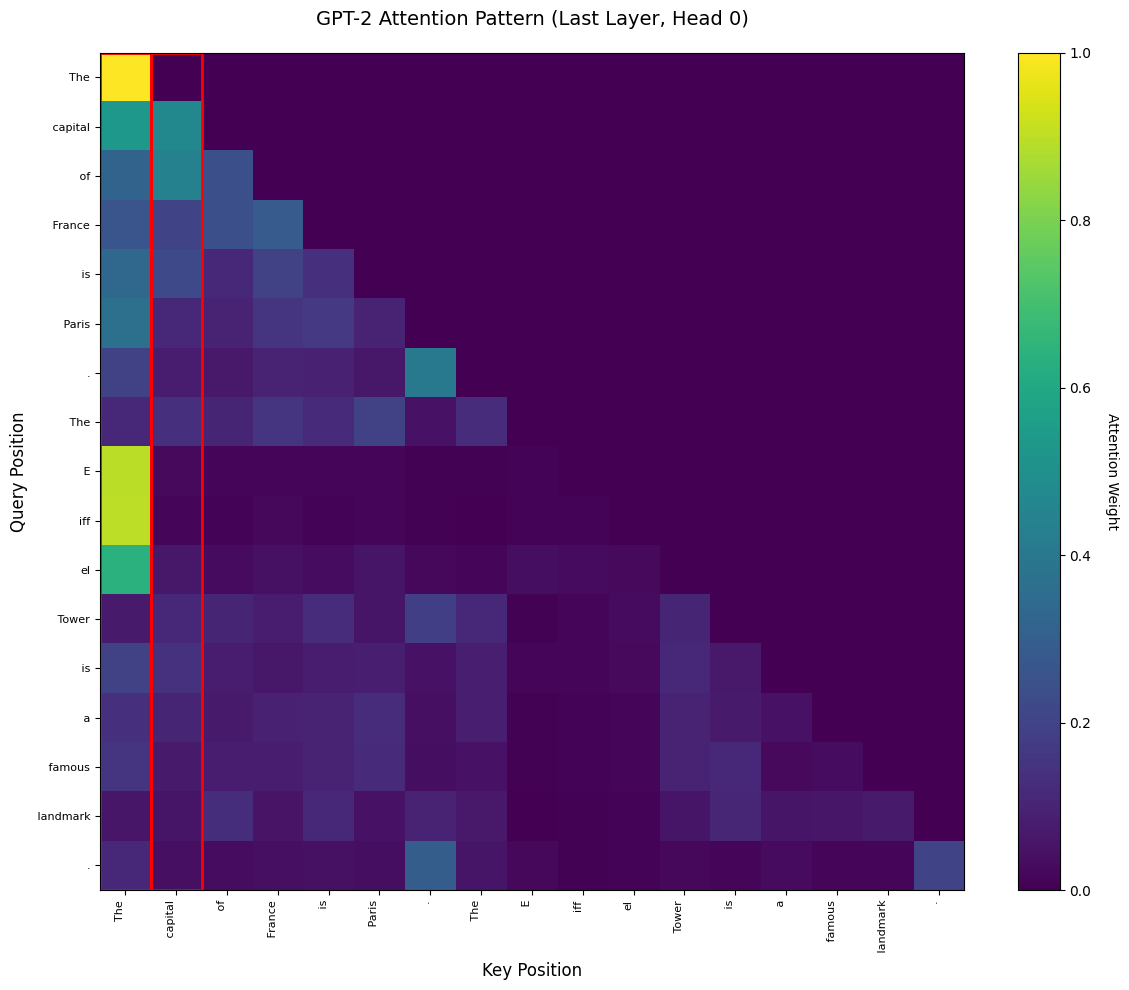


🔴 Attention Sinks detected at positions: [0, 1]
Sink tokens: ['The', ' capital']

Average attention per position:
🔴  0. The             0.3699
🔴  1.  capital        0.1352
    2.  of             0.0832
    3.  France         0.0807
    4.  is             0.0665
    5.  Paris          0.0544
    6. .               0.0702
    7.  The            0.0357
    8.  E              0.0064
    9. iff             0.0057
   10. el              0.0077
   11.  Tower          0.0288
   12.  is             0.0224
   13.  a              0.0096
   14.  famous         0.0063
   15.  landmark       0.0051
   16. .               0.0120


In [6]:
# Visualize attention heatmap
if attention_data is not None:
    attention_matrix = np.array(attention_data)
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(attention_matrix, cmap='viridis', aspect='auto')
    
    # Set ticks
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90, ha='right', fontsize=8)
    ax.set_yticklabels(tokens, fontsize=8)
    
    # Labels
    ax.set_xlabel('Key Position', fontsize=12)
    ax.set_ylabel('Query Position', fontsize=12)
    ax.set_title('GPT-2 Attention Pattern (Last Layer, Head 0)', fontsize=14, pad=20)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight', rotation=270, labelpad=20)
    
    # Identify sinks (high average attention)
    avg_attention = attention_matrix.mean(axis=0)
    sink_threshold = 0.1
    sink_indices = np.where(avg_attention > sink_threshold)[0]
    
    # Highlight sinks with red boxes
    for idx in sink_indices:
        ax.add_patch(plt.Rectangle((idx-0.5, -0.5), 1, len(tokens), 
                                   fill=False, edgecolor='red', linewidth=2))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🔴 Attention Sinks detected at positions: {sink_indices.tolist()}")
    print(f"Sink tokens: {[tokens[i] for i in sink_indices]}")
    print(f"\nAverage attention per position:")
    for i, (token, attn) in enumerate(zip(tokens, avg_attention)):
        marker = "🔴" if i in sink_indices else "  "
        print(f"{marker} {i:2d}. {token:15s} {attn:.4f}")


## Section 4: Needle in a Haystack - Entity Preservation Test

This test checks if critical entities (like "Alice") survive cache eviction under different policies.


In [7]:
# Define prompt with specific entity
needle_prompt = (
    "Alice went to the market and bought fresh vegetables. "
    "The weather was nice and sunny. Many people were shopping. "
    "She met her friend Bob near the fruit stand. "
    "They discussed their weekend plans and decided to meet again."
)

# Entity to track
entity = "Alice"

# Tokenize and find entity position
inputs = tokenizer(needle_prompt, return_tensors="pt")
input_ids = inputs["input_ids"]
tokens = [tokenizer.decode([tok]) for tok in input_ids[0]]

# Find entity token index
entity_token_idx = None
entity_token = None
for i, token in enumerate(tokens):
    if entity.lower() in token.lower():
        entity_token_idx = i
        entity_token = token
        break

print(f"Prompt: {needle_prompt}")
print(f"\nTotal tokens: {len(tokens)}")
print(f"Target entity: '{entity}'")
print(f"Entity token: '{entity_token}' at position {entity_token_idx}")
print(f"\nAll tokens: {tokens}")


Prompt: Alice went to the market and bought fresh vegetables. The weather was nice and sunny. Many people were shopping. She met her friend Bob near the fruit stand. They discussed their weekend plans and decided to meet again.

Total tokens: 43
Target entity: 'Alice'
Entity token: 'Alice' at position 0

All tokens: ['Alice', ' went', ' to', ' the', ' market', ' and', ' bought', ' fresh', ' vegetables', '.', ' The', ' weather', ' was', ' nice', ' and', ' sunny', '.', ' Many', ' people', ' were', ' shopping', '.', ' She', ' met', ' her', ' friend', ' Bob', ' near', ' the', ' fruit', ' stand', '.', ' They', ' discussed', ' their', ' weekend', ' plans', ' and', ' decided', ' to', ' meet', ' again', '.']


In [8]:
# Capture attention for the needle prompt
with SinkVis(model, tokenizer) as sv:
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    # Get attention matrix
    attention_data = sv.get_attention_data(layer=-1, head=0)
    attention_matrix = np.array(attention_data)
    
print(f"✓ Captured attention matrix: {attention_matrix.shape}")


✓ Captured attention matrix: (43, 43)


In [9]:
# Define cache budget (smaller than sequence length to force eviction)
cache_budget = 20  # Keep only 20 tokens out of ~40
sink_count = 4

# Policies to compare
policies = [
    ("Full", EvictionPolicy.FULL, len(tokens)),
    ("Sliding Window", EvictionPolicy.SLIDING_WINDOW, cache_budget),
    ("StreamingLLM", EvictionPolicy.STREAMING_LLM, cache_budget),
    ("H2O", EvictionPolicy.H2O, cache_budget),
]

results = []

print(f"\n{'='*70}")
print(f"Running simulations with cache budget: {cache_budget} tokens")
print(f"Sequence length: {len(tokens)} tokens")
print(f"Sink count: {sink_count}")
print(f"{'='*70}\n")



Running simulations with cache budget: 20 tokens
Sequence length: 43 tokens
Sink count: 4



In [10]:
from sinkvis.simulation import (
    simulate_lru,
    simulate_sliding_window,
    simulate_streaming_llm,
    simulate_h2o,
)

# Run simulations for each policy
for policy_name, policy_type, budget in policies:
    print(f"\n{'─'*70}")
    print(f"Policy: {policy_name} (budget: {budget})")
    print(f"{'─'*70}")
    
    # Generate keep mask based on policy
    if policy_name == "Full":
        mask = np.ones(len(tokens), dtype=bool)
    elif policy_name == "Sliding Window":
        mask = simulate_sliding_window(len(tokens), budget)
    elif policy_name == "StreamingLLM":
        mask = simulate_streaming_llm(len(tokens), budget, sink_count)
    elif policy_name == "H2O":
        mask, _ = simulate_h2o(attention_matrix, budget, sink_count)
    elif policy_name == "LRU":
        mask, _ = simulate_lru(attention_matrix, budget)
    
    # Calculate VRAM usage (simplified estimation)
    # Assume each token's KV cache takes ~2KB (key + value vectors)
    bytes_per_token = 2048  # 2KB
    num_layers = model.config.n_layer
    kept_tokens = mask.sum()
    vram_mb = (kept_tokens * bytes_per_token * num_layers) / (1024 * 1024)
    
    # Check if entity token is preserved
    entity_preserved = mask[entity_token_idx] if entity_token_idx is not None else False
    
    # Store results
    results.append({
        'policy': policy_name,
        'vram_mb': vram_mb,
        'kept_tokens': kept_tokens,
        'entity_preserved': entity_preserved,
        'mask': mask,
    })
    
    # Print results
    print(f"Tokens kept: {kept_tokens}/{len(tokens)}")
    print(f"VRAM usage: {vram_mb:.2f} MB")
    print(f"Entity '{entity}' preserved: {'✓ YES' if entity_preserved else '✗ NO'}")
    
    # Show which tokens are kept
    kept_indices = np.where(mask)[0]
    kept_token_strs = [tokens[i] for i in kept_indices]
    print(f"\nKept token positions: {kept_indices.tolist()}")
    print(f"Kept tokens: {kept_token_strs}")
    
    # Highlight if entity position is in kept set
    if entity_token_idx is not None:
        if entity_preserved:
            print(f"✓ Entity token '{entity_token}' at position {entity_token_idx} is PRESERVED")
        else:
            print(f"✗ Entity token '{entity_token}' at position {entity_token_idx} was EVICTED")

print(f"\n{'='*70}")
print("Simulation complete!")
print(f"{'='*70}")



──────────────────────────────────────────────────────────────────────
Policy: Full (budget: 43)
──────────────────────────────────────────────────────────────────────
Tokens kept: 43/43
VRAM usage: 1.01 MB
Entity 'Alice' preserved: ✓ YES

Kept token positions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
Kept tokens: ['Alice', ' went', ' to', ' the', ' market', ' and', ' bought', ' fresh', ' vegetables', '.', ' The', ' weather', ' was', ' nice', ' and', ' sunny', '.', ' Many', ' people', ' were', ' shopping', '.', ' She', ' met', ' her', ' friend', ' Bob', ' near', ' the', ' fruit', ' stand', '.', ' They', ' discussed', ' their', ' weekend', ' plans', ' and', ' decided', ' to', ' meet', ' again', '.']
✓ Entity token 'Alice' at position 0 is PRESERVED

──────────────────────────────────────────────────────────────────────
Policy: Sliding Window (budget: 20)
───────────

## Visualize Results: Entity Preservation by Policy


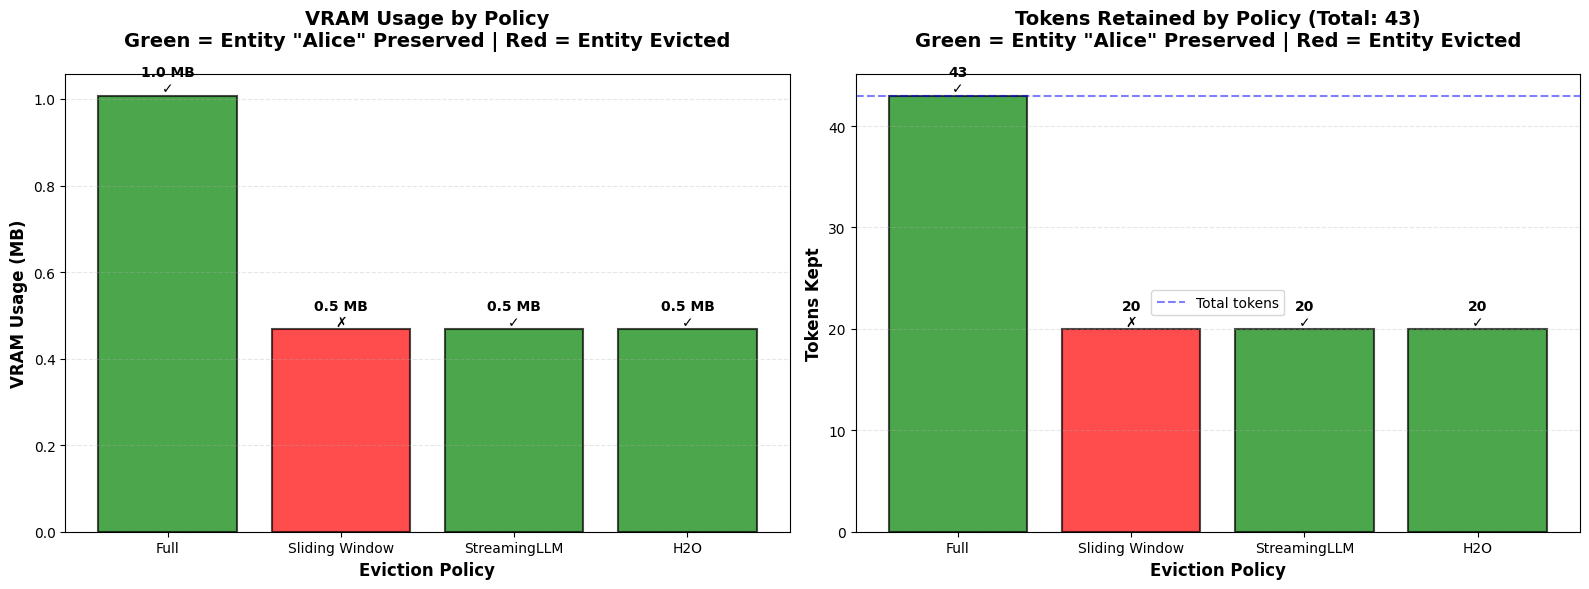


Policy               VRAM (MB)       Tokens Kept     Entity Preserved    
Full                 1.01            43              ✓ YES               
Sliding Window       0.47            20              ✗ NO                
StreamingLLM         0.47            20              ✓ YES               
H2O                  0.47            20              ✓ YES               


In [11]:
# Create bar chart with color coding
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Extract data
policy_names = [r['policy'] for r in results]
vram_usage = [r['vram_mb'] for r in results]
entity_preserved = [r['entity_preserved'] for r in results]
kept_tokens = [r['kept_tokens'] for r in results]

# Color code: Green if entity preserved, Red if evicted
colors = ['green' if preserved else 'red' for preserved in entity_preserved]

# Plot 1: VRAM Usage
bars1 = ax1.bar(policy_names, vram_usage, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('VRAM Usage (MB)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Eviction Policy', fontsize=12, fontweight='bold')
ax1.set_title(f'VRAM Usage by Policy\nGreen = Entity "{entity}" Preserved | Red = Entity Evicted', 
              fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, vram, preserved in zip(bars1, vram_usage, entity_preserved):
    height = bar.get_height()
    symbol = '✓' if preserved else '✗'
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{vram:.1f} MB\n{symbol}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# Plot 2: Tokens Kept
bars2 = ax2.bar(policy_names, kept_tokens, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Tokens Kept', fontsize=12, fontweight='bold')
ax2.set_xlabel('Eviction Policy', fontsize=12, fontweight='bold')
ax2.set_title(f'Tokens Retained by Policy (Total: {len(tokens)})\nGreen = Entity "{entity}" Preserved | Red = Entity Evicted', 
              fontsize=14, fontweight='bold', pad=20)
ax2.axhline(y=len(tokens), color='blue', linestyle='--', alpha=0.5, label='Total tokens')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.legend()

# Add value labels
for bar, kept, preserved in zip(bars2, kept_tokens, entity_preserved):
    height = bar.get_height()
    symbol = '✓' if preserved else '✗'
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{kept}\n{symbol}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*80)
print(f"{'Policy':<20} {'VRAM (MB)':<15} {'Tokens Kept':<15} {'Entity Preserved':<20}")
print("="*80)
for r in results:
    preserved_str = '✓ YES' if r['entity_preserved'] else '✗ NO'
    print(f"{r['policy']:<20} {r['vram_mb']:<15.2f} {r['kept_tokens']:<15} {preserved_str:<20}")
print("="*80)


## Visualize Token Retention Patterns


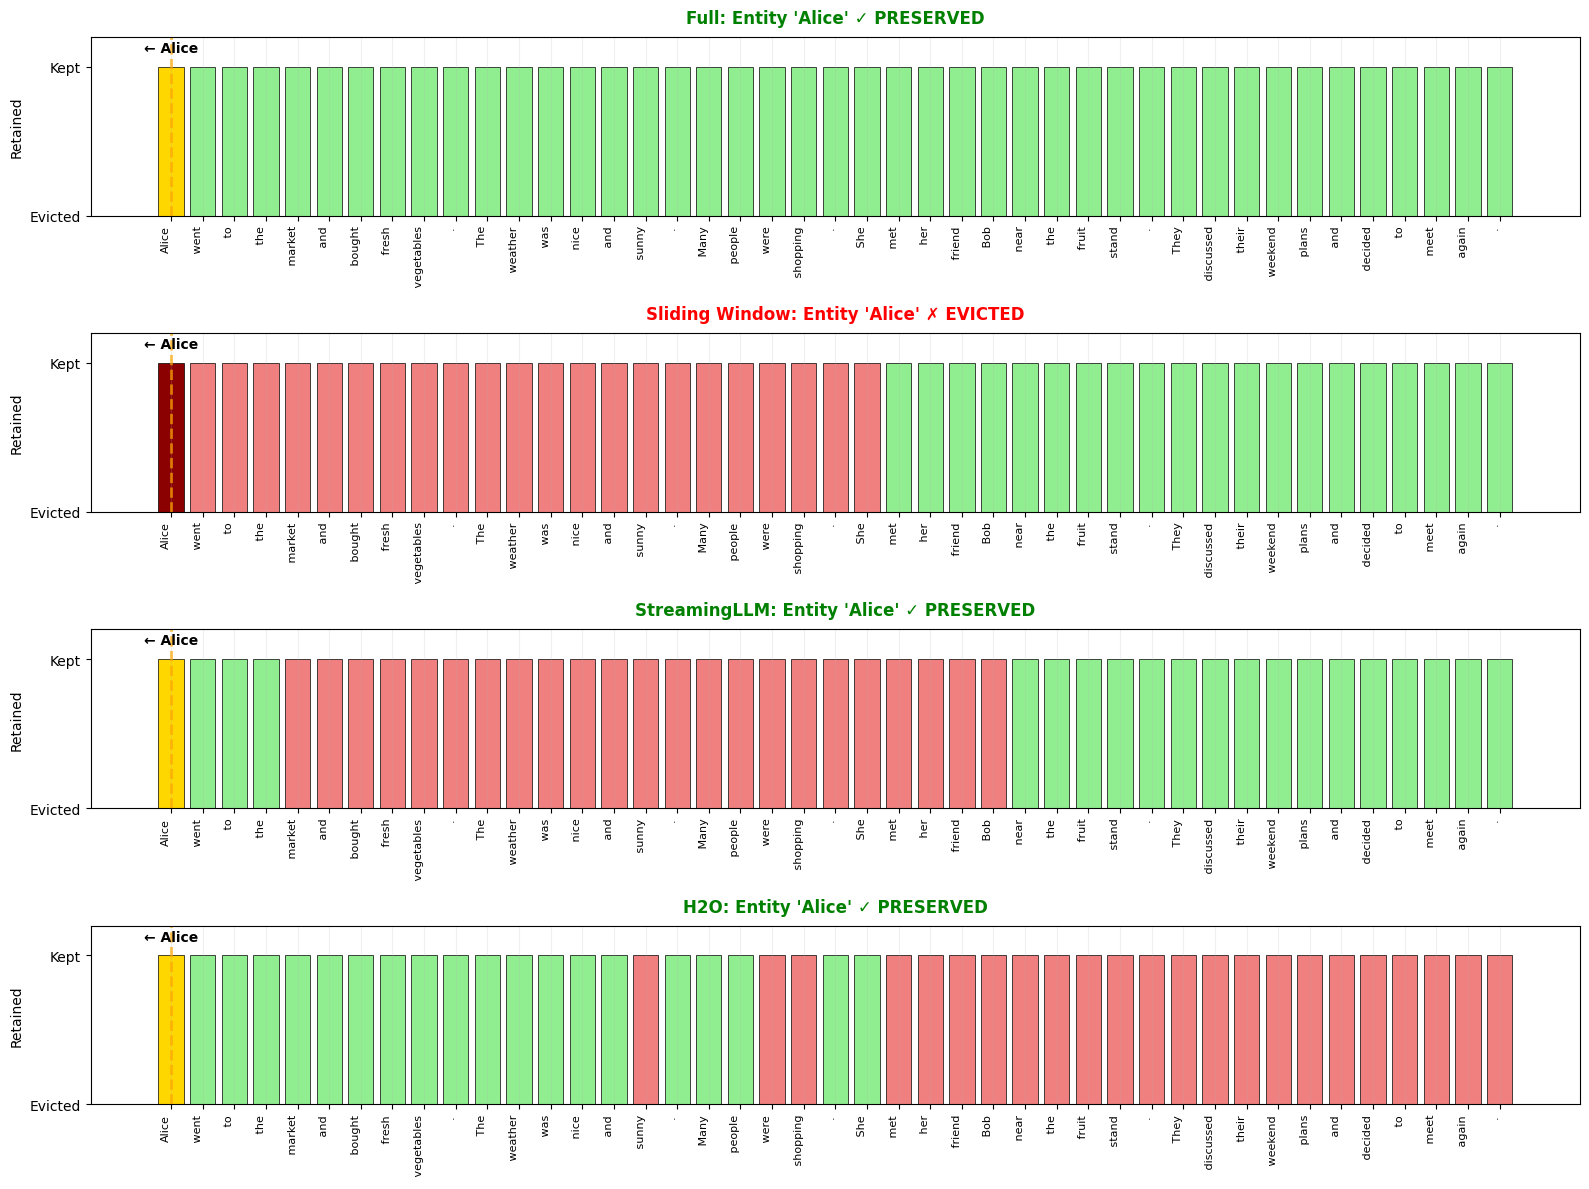

In [12]:
# Create a visual representation of which tokens are kept
fig, axes = plt.subplots(len(results), 1, figsize=(16, 3*len(results)))

if len(results) == 1:
    axes = [axes]

for ax, result in zip(axes, results):
    mask = result['mask']
    policy = result['policy']
    entity_preserved = result['entity_preserved']
    
    # Create color array: green for kept, red for evicted
    colors = ['lightgreen' if m else 'lightcoral' for m in mask]
    
    # Highlight entity token
    if entity_token_idx is not None:
        colors[entity_token_idx] = 'gold' if entity_preserved else 'darkred'
    
    # Create bar chart
    positions = range(len(tokens))
    ax.bar(positions, np.ones(len(tokens)), color=colors, edgecolor='black', linewidth=0.5)
    
    # Set labels
    ax.set_xticks(positions)
    ax.set_xticklabels(tokens, rotation=90, ha='right', fontsize=8)
    ax.set_ylabel('Retained', fontsize=10)
    ax.set_ylim(0, 1.2)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Evicted', 'Kept'])
    
    # Title with entity preservation status
    status = '✓ PRESERVED' if entity_preserved else '✗ EVICTED'
    title_color = 'green' if entity_preserved else 'red'
    ax.set_title(f"{policy}: Entity '{entity}' {status}", 
                fontsize=12, fontweight='bold', color=title_color, pad=10)
    
    # Add vertical line at entity position
    if entity_token_idx is not None:
        ax.axvline(x=entity_token_idx, color='orange', linestyle='--', linewidth=2, alpha=0.7)
        ax.text(entity_token_idx, 1.1, f'← {entity}', ha='center', fontweight='bold', fontsize=10)
    
    ax.grid(axis='x', alpha=0.2)

plt.tight_layout()
plt.show()


## Key Insights

From the "Needle in a Haystack" experiment:

1. **Full Cache**: Always preserves all tokens (baseline)
2. **Sliding Window**: May evict important tokens from the beginning
3. **StreamingLLM**: Preserves attention sinks (first tokens) + recent window
4. **H2O**: Preserves tokens based on attention scores (heavy hitters)

**Critical Finding**: 
- If your entity "Alice" appears early, **StreamingLLM** will preserve it (via sinks)
- If "Alice" has high attention, **H2O** will preserve it (via heavy hitter detection)
- **Sliding Window** may lose it entirely if it's not in the recent window

This demonstrates why **attention-aware policies** (StreamingLLM, H2O) outperform naive approaches for maintaining context coherence!


## Summary

This notebook demonstrated:

✅ **Loading GPT-2** and capturing real attention patterns  
✅ **Using SinkVis** context manager for instrumentation  
✅ **Visualizing attention sinks** with heatmaps  
✅ **Comparing eviction policies** (Full, Sliding Window, StreamingLLM, H2O)  
✅ **Needle in a Haystack test** - checking entity preservation  
✅ **VRAM calculation** for each policy  
✅ **Color-coded visualization** showing preservation success  

**Next Steps:**
- Try different models (e.g., `gpt2-medium`, `distilgpt2`)
- Experiment with longer sequences
- Adjust cache budgets and sink counts
- Test with domain-specific prompts
